# Introduction

**Problem:** Determine the equation of motion of a body or collection of bodies given initial conditions of the system

**Solution:** AD. Allows machine precision computation of derivatives, which can be used in the computation of Jacobians involved in implicit differentiation.

# Background

## Euler's Method
The motivation is the following: 

* We have some initial conditions, like position and velocity of a planet, and we want to know what kind of orbit this planet will trace out, given that only the force acting on it is gravity. 
* Using the physical insight that the "slope" of position over time is velocity, and the "slope" of velocity over time is acceleration, we can predict, or integrate, how the quantities will change over time. 
* More explicitly, we can use the acceleration supplied by gravity to predict the velocity of our planet, and then use this velocity to predict its position a timestep $\Delta t$ later. 
* This gives us a new position and the whole process starts over again at the next timestep. Here is a schematic of the Euler integration method.
<img src="http://jmahaffy.sdsu.edu/courses/f00/math122/lectures/num_method_diff_equations/images/euler_ani.gif">

This plot above could represent anything. It could be how one component of the planet's velocity varies over time, or it could be the position of the end of a spring as it slinks back and forth. The point is that we have some solution curve (black) that we want to approximate (red), given that we only know two things:
* where we started $(t_0, y_0)$
* the rate of how where we were changes with time $\left(y'_0 = \frac{y_1 - y_0}{\Delta t}\right)$

The beauty of this is that even though we do not explicity know what $y_1$ is, the fact that we are given $y'_0$ from the initial conditions allows us to bootstrap our way around this. Starting with the definition of slope, we can use the timestep $h = \Delta t$, to find where we will be a timestep later $y_1$:
\begin{align*}
 y_0' = \frac{y_1 - y_0}{\Delta t}\quad\longrightarrow\quad
 y_1 = y_0 + \Delta t\ y_0'\quad.
\end{align*}

Generalizing to any timestep $n$:
\begin{align*}
y_{n+1} = y_n + \Delta t\ y_n'
\end{align*}

Whenever all of the $n+1$ terms are on one side of the equation and the $n$ terms are on the other, we have something called an *explicit numerical method* This is intuitively straightforward and easy to implement, but there is a downside, the solutions **do not converge** for a given timestep.

## Example

Here is an example of Euler's method going wrong, applied to a simple harmonic oscillator with mass $m$ and spring stiffness constant $k$. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'

# initial conditions
x_old = 10
v_old = 0
k = 1
m = 1
t_max = 100
h = .1 # timestep

xs = [] # holds positions
vs = [] # holds veclocities

# run simulation
t = 0
while t < t_max:
    # explicit Euler method
    v_new = v_old - h*(k/m)*x_old
    x_new = x_old + h*v_old
    
    # update
    xs.append(x_new)
    vs.append(v_new)
    x_old = x_new
    v_old = v_new
    t += h

plt.plot(xs)
plt.xlabel('step')
plt.ylabel('x')
plt.title('Explicit Euler Method')

Text(0.5,1,'Explicit Euler Method')

It blows up! To see why this is, we can investigate the simpler *stiff oscillator*. The notation used here will also set the framework for the math conventions used in the development of this package.

### Stiff Oscillator


Instead of worrying about what the actual equation of motion of our spring in the previous example looks like, we can consider an oscillator with some motion $x(t)$ along the x-axis confined to an area that is close to this axis. In other words,
$$
\newcommand{b}[1]{\mathbf#1}
\newcommand{od}[2]{\frac{\mathrm{d}#1}{\mathrm{d}#2}}
\begin{align*}
\b f(\b X_n) = \dot{\b X}_n = \od{}{t}\begin{bmatrix}x_n\\y_n\end{bmatrix}
= \begin{bmatrix}-x_n\\-ky_n\end{bmatrix}
\end{align*}\quad,
$$

for large $k$ to constrain our oscillator to the x-axis.

Running our explicit Euler scheme then gives,
$$
\begin{align*}
\b X_{n+1} = \b X_n + h\b f(\b X_n) 
= \begin{pmatrix}x_0\\y_0\end{pmatrix}
+ h\begin{pmatrix}-x_0\\-ky_0\end{pmatrix}
= \begin{bmatrix}(1 - h)x_0\\(1 - hk) y_0\end{bmatrix}
\end{align*}\quad.
$$

This is our problem. If $|1 - hk| > 0$, then $|y_{n+1}| > |y_n|$, which would imply that our spring would actually get farther and farther away from the x-axis! In other words, if we happened to select a timestep larger than $h = 2/k$, our solution would not converge. By definition, $k$ is large, so the only way to avoid having this system blow up on us is to select very small timesteps, which is computationally expensive and would take forever to run. 

We need a scheme that will remain stable for a wide range of timesteps, which is what *implicit differentiation can accomplish*. The most straightforward example of such a scheme is the **Backward Euler Method**.

## Backward Euler Method

Conceptually, this method is identical to the **Euler Method**, with the only difference being that we use the slope at the end of the timestep instead of the beginning to propogate our solution. In other words,
$$
\newcommand{D}{\Delta\b X}
\begin{align*}
\b X_{n+1} = \b X_n + h\b f(\b X_{n+1})\quad.
\end{align*}
$$

In general, it's pretty tough to solve for $\b X_{n+1}$ exactly, so let's approximate instead up to first order in its Taylor series instead. To simplify notation a bit, $\D \equiv \b X_{n+1} - \b X_n$. We can now write the above scheme as,
$$
\begin{align*}
\b X_n + \D = \b X_n + h\b f(\b X_n+\D)\quad,
\end{align*}
$$

then cancel like terms and expand to first order in $\D$ to get,
$$
\begin{align*}
\D \approx h\left[\b f(\b X_n) + f'(\b X_n)\D\right]\quad.
\end{align*}
$$

Solving for $\D$, we have
$$
\begin{align*}
\D = \left[\frac{1}{h}\b I - f'(\b X_n)\right]^{-1} f(\b X_n)\quad,
\end{align*}
$$

where $\b I$ is the identity matrix.

Alright, that was a whole bunch of abstraction. Let's actually put it into practice by applying it to our stiff spring system. Just collecting some pieces together, we have
$$
\newcommand{\pd}[2]{\frac{\partial#1}{\partial#2}}
\begin{align*}
\b f(\b X_n) &= \begin{pmatrix}-x_n\\-ky_n\end{pmatrix} \\
f'(\b X_n) &= \pd{}{\b X_n}\b f(\b X_n) = \begin{pmatrix}-1&0\\0&-k\end{pmatrix} \\
\frac{1}{h}\b I - f'(\b X_n) &= 
\begin{pmatrix}\frac{1}{h} + 1 & 0\\0 & \frac{1}{h}+k\end{pmatrix}
= \begin{pmatrix}\frac{1+h}{h} & 0\\0 & \frac{1+kh}{h}\end{pmatrix} \\
\left[\frac{1}{h}\b I - f'(\b X_n)\right]^{-1} &= \frac{h^2}{(1 + h)(1 + kh)}
\begin{pmatrix}\frac{1 + kh}{h} & 0\\0 & \frac{1+h}{h}\end{pmatrix}
= \begin{pmatrix}\frac{h}{1 + h} & 0\\0 & \frac{h}{1 + kh}\end{pmatrix}\quad.
\end{align*}
$$

Putting it all together,
$$
\begin{align*}
\D = \begin{pmatrix}\frac{h}{1 + h} & 0\\0 & \frac{h}{1 + kh}\end{pmatrix}
\begin{pmatrix}-x_0\\-ky_0\end{pmatrix}
= -\begin{pmatrix}\frac{h}{1 + h}x_0\\\frac{h}{1 + kh}ky_0\end{pmatrix}\quad.
\end{align*}
$$

In the limit of large $h$, this just collapses down to $-(x_0, y_0) = -\b X_n$. So we have, $\b X_{n+1} = \b X_n + \D  = 0$. The system converges in a single timestep! This is just by design for a stiff oscillator. Other systems will not always converge for an arbitrarily large timestep for this implicit integration scheme, but they will still tend to converge without needing to use extremely small timesteps. 

We can similarly extend this to second order differential equations, which our orbital dynamics application will use. The methodology is outlined in the next section.

### Extending to Second order ODEs

Converting our second order differential equation $\ddot{x}_n = f(\b x_n, \b v_n)$ into two coupled single order ODE's again (like we did for the simple harmonic oscillator example),
$$
\begin{align*}
\od{}{t}\begin{pmatrix}\b x_n\\\b v_n\end{pmatrix}
= \begin{bmatrix}\b v\\\b f(\b x_n, \b v_n)\end{bmatrix}\quad.
\end{align*}
$$

Recasting this in our $\Delta$ notation,
$$
\newcommand{\Dx}{\Delta\b x}
\newcommand{\Dv}{\Delta\b v}
\begin{pmatrix}\Dx\\\Dv\end{pmatrix} 
= h\begin{bmatrix}\b v_n + \Dv\\\b f(\b x_n+\Dx, \b v_n+\Dv)\end{bmatrix}\quad.
$$

Expanding to first order (and allowing for the possibility that $\b f$ can vary with explicitly with time),
$$
\newcommand{dfdx}{\frac{\partial\b f}{\partial\b x_n}}
\newcommand{dfdv}{\frac{\partial\b f}{\partial\b v_n}}
\newcommand{dfdt}{\frac{\partial\b f}{\partial t}}
\begin{align*}
\begin{pmatrix}\Dx\\\Dv\end{pmatrix} \approx
h\begin{bmatrix}\b v_n + \Dv\\\b f_n + \dfdx\Dx + \dfdv\Dv + \dfdt\end{bmatrix}\quad.
\end{align*}
$$

Subbing the top row into the bottom,
$$
\begin{align*}
\Dv = h\left[\b f_n+\dfdx h(\b v_n+\Dv) + \dfdv\Dv + \b f(t)\right]\quad.
\end{align*}
$$

Solving for $\Dv$,
$$
\begin{align*}
&\left(\frac{1}{h}\b I - h\dfdx - \dfdv\right)\Dv
= \b f_n + h\dfdx\b v_n + \dfdt \\ 
&\Longrightarrow\quad
\Dv = \left(\frac{1}{h}\b I - h\dfdx - \dfdv\right)^{-1}
\left(\b f_n + h\dfdx\b v_n + \dfdt\right)\quad.
\end{align*}
$$

From there, $\Dx$ is just $h(v_n + \Dv)$.

Let's apply this to our spring system that blew up before!

### Application to Simple Harmonic Oscillator

Collecting the relevant relations together again (just using two dimensions for simplicity),
$$
\begin{align*}
&\b f_n = \begin{pmatrix}-\frac{k}{m}x_n \\ 0\end{pmatrix},\quad
\dfdx = \begin{pmatrix}-\frac{k}{m} & 0\\ 0 & 0\end{pmatrix},\quad
\dfdv = \b 0, \quad \dfdt = \b 0\quad,\\
&\left[\frac{1}{h}\b I - h\begin{pmatrix}-\frac{k}{m}&0\\0&0\end{pmatrix}\right]^{-1}
= \left[\begin{pmatrix}\frac{1}{h}&0\\0&\frac{1}{h}\end{pmatrix}
- \begin{pmatrix}-\frac{hk}{m}&0\\0&0\end{pmatrix}\right]^{-1}
= \begin{bmatrix}\frac{m+h^2k}{hm}&0\\0&\frac{1}{h}\end{bmatrix}^{-1}
= \frac{h^2 m}{m + h^2 k}\begin{pmatrix}\frac{1}{h}&0\\0&\frac{m+h^2 k}{hm}\end{pmatrix}
\quad.
\end{align*}
$$

Plugging it all in,
$$
\begin{align*}
\Dv &= \frac{h^2 m}{m + h^2 k}
\begin{pmatrix}\frac{1}{h}&0\\0&\frac{m+h^2 k}{hm}\end{pmatrix}
\left[\begin{pmatrix}-\frac{k}{m}x_n\\0\end{pmatrix}
+ h\begin{pmatrix}-\frac{k}{m}&0\\0&0\end{pmatrix}
\begin{pmatrix}v_n\\0\end{pmatrix}\right] \\
&= \begin{pmatrix}\frac{hm}{m+h^2m}&0\\0&h\end{pmatrix}
\begin{pmatrix}-\frac{k}{m}x_n-\frac{hk}{m}\\0\end{pmatrix}
= \begin{bmatrix}-\frac{hk(x_n+h)}{m(1+h^2)}\\0\end{bmatrix}\quad.
\end{align*}
$$

Applying this to the simple harmonic oscillator using the same initial conditions gives the following results:

Text(0.5,1,'Backward Euler Method')

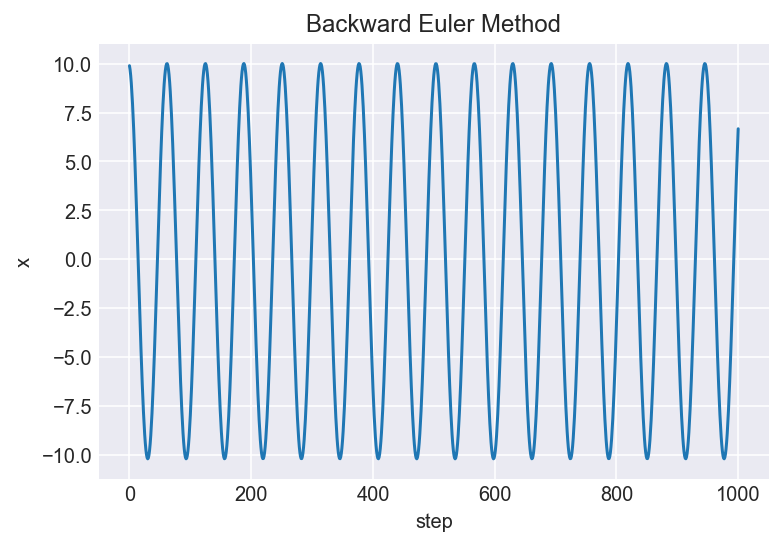

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'

# initial conditions
x_old = 10
v_old = 0
k = 1
m = 1
t_max = 100
h = .1 # timestep

xs = [] # holds positions
vs = [] # holds veclocities

# run simulation
t = 0
while t < t_max:
    # implicit Euler method
    delta_v = -h*k*(x_old + h) / (m * (1 + h**2))
    v_new = v_old + delta_v
    delta_x = h*v_new
    x_new = x_old + delta_x
    
    # other method? This seems to work too
    #v_new = v_old - h*(k/m)*x_old
    #x_new = x_old + h*v_new
    
    # update
    xs.append(x_new)
    vs.append(v_new)
    x_old = x_new
    v_old = v_new
    t += h

plt.plot(xs)
plt.xlabel('step')
plt.ylabel('x')
plt.title('Backward Euler Method')

The spring has a stable solution = D

For more complex functions, accurately computing the Jacobian can be numerically intensive though. Enter: **Automatic Differentiation**

## Automatic Differentiation

This is a method to simultaneously compute a function and its derivative to machine precision. This can be done by introducing the dual number $\epsilon^2=0$, where $\epsilon\ne0$. If we transform some arbitrary function $f(x)$ to $f(x+\epsilon)$ and expand it, we have:
$$
\begin{align*}
f(x+\epsilon) = f(x) + \epsilon f'(x) + O(\epsilon^2)\quad.
\end{align*}
$$

By the definition of $\epsilon$, all second order and higher terms in $\epsilon$ vanish and we are left with $f(x+\epsilon) = f(x) + \epsilon f'(x)$, where the dual part, $f'(x)$, of this transformed function is the derivative of our original function $f(x)$. If we adhere to the new system of algebra introduced by dual numbers, we are able to comput derivatives of functions exactly. 

For example, multiplying two dual numbers $z_1 = a_r + \epsilon a_d$ and 
$z_2 = b_r + \epsilon b_d$ would behave like:
$$
z_1 \times z_2 = (a_r + \epsilon a_d) \times (b_r + \epsilon b_d)
= a_rb_r + \epsilon(a_rb_d + a_db_r) + \epsilon^2 a_db_d
= \boxed{a_rb_r + \epsilon(a_rb_d + a_db_r)}\quad.
$$

Operations like this can be redefined via *operator overloading*

## Operator Overloading

Blah blah, `__radd__`, `__truediv__`, blah

# Software Organization

The structure of our package is shown below
    
    AutoDiff/ 
    
        AutoDiff/
            __init__.py
            dual_numbers.py
            autodiff.py
        
        Tests/
            __init__.py
            test_autodiff.py

        README.md
        setup.py
        LICENSE
        MANIFEST.in
        .gitignore

## What is in each file?

### __init__.py in AutoDiff
```python
from .module1 import class1, method1, method2 
from .module2 import class2

__all__ = ['class1', 'method1', 'method2','class2']
```

### __init__.py in test directory
```python
name="AutoDiff_SpaceJam"
```

### README.md

### setup.py
```python
from setuptools import setup


def readme():
    with open('README.rst') as f:
        return f.read()


setup(name='AutoDiff_Orbit',
      version='0.1',
      description='Automatic differentiation used to calculate orbit',
      long_description=readme(),
      classifiers=[
        'Development Status :: 3 - Alpha',
        'License :: OSI Approved :: MIT License',
        'Programming Language :: Python :: 3.6',
        'Topic :: Text Processing :: Linguistic',
      ],
      keywords='automatic differentiation orbit dual',
      url='http://github.com/[CS207_SpaceJam]',
      author='SpaceJam',
      license='MIT',
      packages=['AutoDiff'],
      install_requires=[
          'markdown',
      ],
      test_suite='nose.collector',
      tests_require=['nose', 'nose-cover3'],
      include_package_data=True,
      zip_safe=False)
```

### LICENCE
MIT License

### MANIFEST.in
include README.md

### .gitignore# 
Compiled python modules.

```python
*.pyc
*.ipynb_checkpoints

# Setuptools build folder.
build/

# Setuptools distribution folder.
dist/

# Python egg metadata, regenerated from source files by setuptools.
*.egg-info
*.egg
```

### Dual_Numbers.py
```python
class DualNumber:
    def add:
    def substract:
    def multiply:
    def divide: 
    def sqrt:
    def power:
    def sin:
    def cos:
    def tan:
```

### AutoDiff.py

### test_autodiff.py

```python
import AutoDiff

class TestDual(x):

class TestAutoDiff(TestCase):
    def test_can_run(self):
        x=rand(num_points)
        y=rand(num_points)
        
        x_test=rand(num_test)
        y_test=rand(num_test)
        
        rmse=my_autodiff.rmse_score(y_test, y_predict)
        self.assertTrue(rmse > 0)
```